In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as numpy
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore",category=FutureWarning)


In [ ]:
IMAGE_SIZE = [224,224]

In [ ]:
!ls '/content/drive'

ls: cannot access '/content/drive': No such file or directory


In [ ]:
train_path='/content/drive/MyDrive/dataset/train'
validation_path='/content/drive/MyDrive/dataset/test'

In [ ]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
for layer in vgg.layers:
  layer.trainable=False

In [ ]:
x= Flatten()(vgg.output)
prediction = Dense(11,activation='softmax')(x)
model=Model(inputs=vgg.input,outputs=prediction)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
import keras.backend as K
from tensorflow.keras.optimizers import RMSprop

def f1_score(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))

        recall = TP / (Positives+K.epsilon())
        return recall


    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

        precision = TP / (Pred_Positives+K.epsilon())
        return precision

    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)

    return 2*((precision*recall)/(precision+recall+K.epsilon()))

model.compile(loss= 'categorical_crossentropy',
              optimizer = RMSprop(lr=0.001),
              metrics=['Precision','accuracy','Recall','AUC',f1_score])


#from keras import optimizers
#import tensorflow as tf

#adam=tf.optimizers.Adam()
#model.compile(loss='binary_crossentropy',
 ##            metrics=['accuracy'])


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
from keras import preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')


In [ ]:
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [ ]:
train_set= train_datagen.flow_from_directory(train_path,
                                             target_size=(224,224),
                                             batch_size=3,
                                             class_mode='categorical')
test_set= test_datagen.flow_from_directory(validation_path,
                                           target_size=(224,224),
                                           batch_size=3,
                                           class_mode='categorical')


Found 3164 images belonging to 11 classes.
Found 1080 images belonging to 11 classes.


In [ ]:
train_set.class_indices

{'1': 0,
 '10': 1,
 '11': 2,
 '2': 3,
 '3': 4,
 '4': 5,
 '5': 6,
 '6': 7,
 '7': 8,
 '8': 9,
 '9': 10}

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
Y_pred = model.predict_generator(train_set )
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(train_set.classes, y_pred))
print('Classification Report')
target_names = ['0', '1','2','3','4','5','6','7','8','9','10']
print(classification_report(train_set.classes, y_pred, target_names=target_names))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Confusion Matrix
[[ 62  82  18  78 109  85  14  20  33  28  23]
 [ 96  96  28  63 129 109  19  21  42  45  20]
 [ 13  14   1  20  25  15   4   2   4   9   7]
 [ 21  44   3  23  28  40   7   5  22  14  10]
 [  6  14   5   6  19  22   4   3  12   7   8]
 [ 17  20   5  19  26  19   3   2  14   8   4]
 [  5  10   3   7  17  11   3   1   5   4   3]
 [ 57  85  17  73 125  92  25  27  41  37  27]
 [  8  20   5  18  22  15   3   0  10  12   4]
 [ 50  61  15  52  93  75   6  15  34  22  17]
 [ 18  19   2  13  23  22  10   5   8  10   8]]
Classification Report
              precision    recall  f1-score   support

           0       0.18      0.11      0.14       552
           1       0.21      0.14      0.17       668
           2       0.01      0.01      0.01       114
           3       0.06      0.11      0.08       217
           4       0.03      0.18      0.05       106
           5       0.04      0.14      0.06       137
           6       0.03      0.04      0.04        69
          

In [ ]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(filepath= 'mymodel.h5',
                             verbose=2, save_best_only=True)

callbacks = [checkpoint]


start = datetime.now()

model_history=model.fit_generator(
    train_set,
    validation_data=test_set,
    epochs=20

)
duration = datetime.now() - start
print("training completed in time", duration)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  from ipykernel import kernelapp as app


Epoch 1/20
1055/1055 [==============================] - 2797s 3s/step - loss: 35.9883 - precision: 0.2334 - accuracy: 0.2326 - recall: 0.2323 - auc: 0.5924 - f1_score: 0.2328 - val_loss: 37.9827 - val_precision: 0.2567 - val_accuracy: 0.2565 - val_recall: 0.2565 - val_auc: 0.6006 - val_f1_score: 0.2567
Epoch 2/20
1055/1055 [==============================] - 65s 62ms/step - loss: 39.3083 - precision: 0.2876 - accuracy: 0.2876 - recall: 0.2873 - auc: 0.6203 - f1_score: 0.2876 - val_loss: 65.8272 - val_precision: 0.2152 - val_accuracy: 0.2148 - val_recall: 0.2148 - val_auc: 0.5759 - val_f1_score: 0.2154
Epoch 3/20
1055/1055 [==============================] - 65s 61ms/step - loss: 42.1732 - precision: 0.3090 - accuracy: 0.3088 - recall: 0.3088 - auc: 0.6313 - f1_score: 0.3090 - val_loss: 55.4020 - val_precision: 0.2437 - val_accuracy: 0.2444 - val_recall: 0.2435 - val_auc: 0.6007 - val_f1_score: 0.2437
Epoch 4/20
1055/1055 [==============================] - 64s 60ms/step - loss: 43.2070 - 

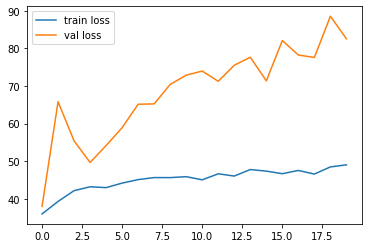

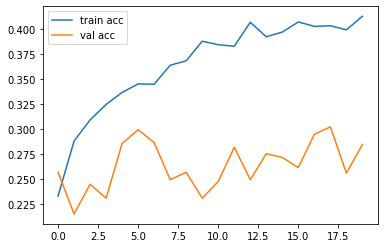

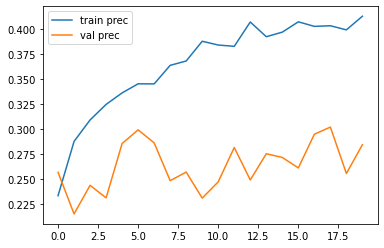

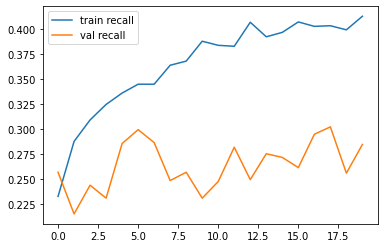

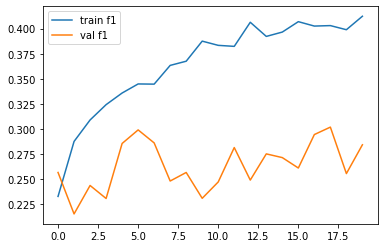

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(model_history.history['loss'], label='train loss')
plt.plot(model_history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(model_history.history['accuracy'], label='train acc')
plt.plot(model_history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

#plot the precision
plt.plot(model_history.history['precision'], label='train prec')
plt.plot(model_history.history['val_precision'], label='val prec')
plt.legend()
plt.show()
plt.savefig('AccVal_prec')

#plot recall
plt.plot(model_history.history['recall'], label='train recall')
plt.plot(model_history.history['val_recall'], label='val recall')
plt.legend()
plt.show()
plt.savefig('AccVal_rec')

#plot f1_score
plt.plot(model_history.history['f1_score'], label='train f1')
plt.plot(model_history.history['val_f1_score'], label='val f1')
plt.legend()
plt.show()
plt.savefig('AccVal_f1')



val [[1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 4.8818027e-29 0.0000000e+00 3.4775560e-16
  0.0000000e+00]]
1


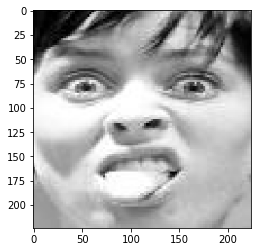

In [ ]:
import numpy as np
img=image.load_img('/content/drive/MyDrive/dataset/test/11/test_670_aligned.jpg',target_size=(224,224,3))
plt.imshow(img)
X=image.img_to_array(img)
X=np.expand_dims(X,axis=0)
images=np.vstack([X])
val=model.predict(images)
print("val %s"%val)
rach=val.argmax()
if rach==0:
  print("1")
if rach==1:
  print("10")
if rach==2:
  print("11")
if rach==3:
  print("2")
if rach==4:
  print("3")
if rach==5:
  print("4")
if rach==6:
  print("5")
if rach==7:
  print("6")
if rach==8:
  print("7")
if rach==9:
  print("8")
if rach==10:
  print("9")

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
img=image.load_img('/content/photo.jpg',target_size=(224,224,3))
plt.imshow(img)
X=image.img_to_array(img)
X=np.expand_dims(X,axis=0)
images=np.vstack([X])
val=model.predict(images)
print("val %s"%val)
rach=val.argmax()
if rach==0:
  print("Happily Surprised")
if rach==1:
  print("Happily Disgusted")
if rach==2:
  print(" Sadly Fearful")
if rach==3:
  print("Sadly Angry")
if rach==4:
  print(" Sadly Surprised")
if rach==5:
  print("Sadly Disgusted")
if rach==6:
  print(" Fearfully Angry")
if rach==7:
  print("Fearfully Surprised")
if rach==8:
  print("Angrily Surprised")
if rach==9:
  print("Angrily Disgusted")
if rach==10:
  print("Disgustedly Surprised")